<a href="https://colab.research.google.com/github/VoKhoiNhon/TimeSerisesForecasting/blob/main/ARIMA_PRICE_VNINDEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')
 
dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y')

  
mydata = pd.read_csv('C:/Users/Admin/Downloads/priceVNI52w2022.csv',index_col='Date',parse_dates=['Date'],date_parser=dateparse).fillna(0)



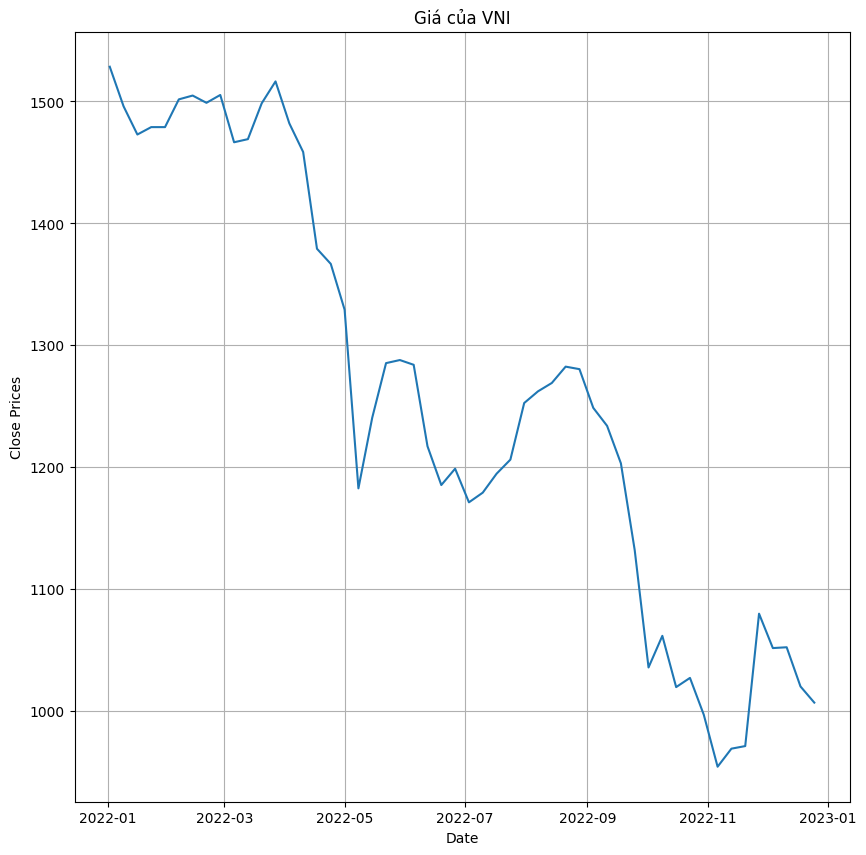

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(mydata['Close'])
plt.title('Giá của VNI')
plt.show()

In [ ]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(mydata['Close'])

Test Statistics                -0.882367
p-value                         0.793724
No. of lags used                0.000000
Number of observations used    51.000000
critical value (1%)            -3.565624
critical value (5%)            -2.920142
critical value (10%)           -2.598015
dtype: float64


In [ ]:
from statsmodels.tsa.statespace.tools import diff
d_mydatad=diff(mydata['Close'])
test_stationarity(d_mydatad)

Test Statistics               -6.449980e+00
p-value                        1.532045e-08
No. of lags used               0.000000e+00
Number of observations used    5.000000e+01
critical value (1%)           -3.568486e+00
critical value (5%)           -2.921360e+00
critical value (10%)          -2.598662e+00
dtype: float64


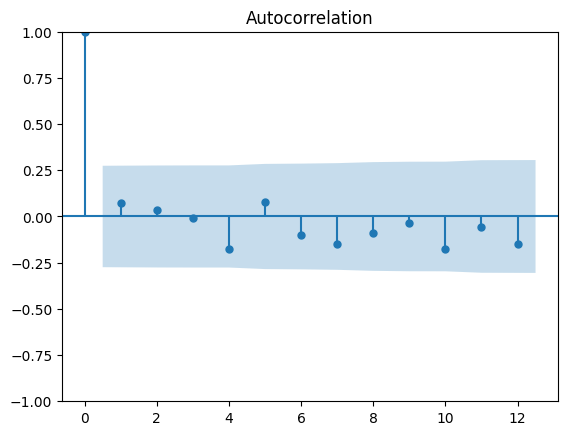

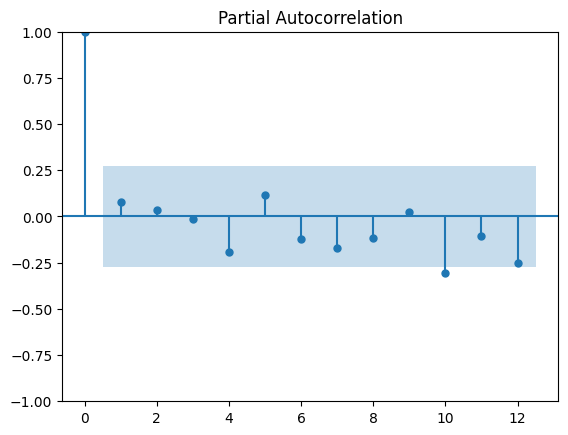

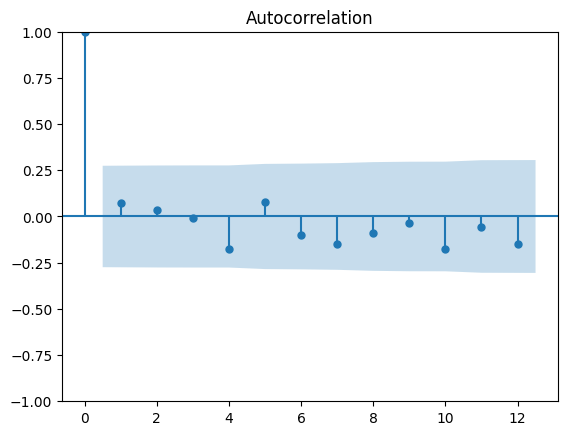

In [ ]:
plot_pacf(d_mydatad,lags=12)
plot_acf(d_mydatad,lags=12)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=524.673, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=526.398, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=526.415, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=525.920, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=528.375, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.097 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -260.336
Date:                Thu, 25 May 2023   AIC                            524.673
Time:                        13:53:30   BIC                            528.536
Sample:                    01-02-2022   HQIC                           526.149
                         - 12-25-2022                                         
Co

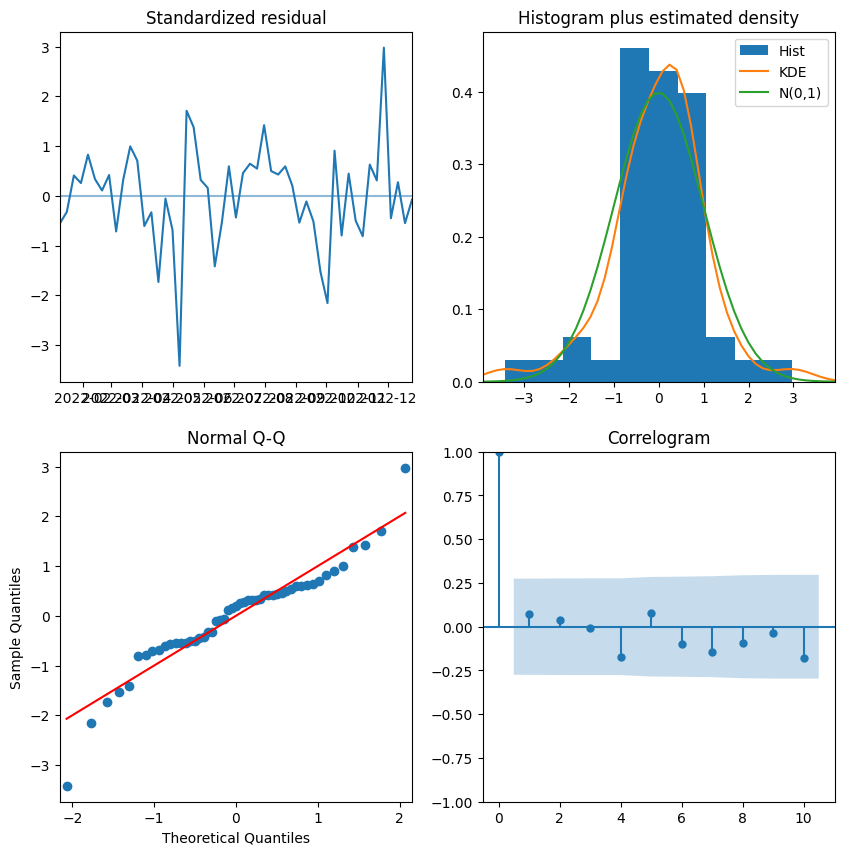

In [ ]:
model_autoARIMA = auto_arima(mydata['Close'], start_p=0, start_q=0,
                      max_p=4, max_q=4,  # p tối đa và q tối đa
                      start_P=0, 
                      d=1,
                      D=0,seasonal=False, 
                      trace=True,
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,10))
plt.show()

      Chi-Sq  Prob>Chi-Sq         F    Prob>F
1   0.030686     0.860943  0.029523  0.864271
2   0.052965     0.973865  0.024980  0.975342
3   0.053792     0.996735  0.016568  0.997054
4   0.063107     0.999513  0.014277  0.999584
5   0.069403     0.999934  0.012295  0.999947
6   0.071660     0.999993  0.010350  0.999994
7   0.081517     0.999999  0.009869  0.999999
8   0.083178     1.000000  0.008611  1.000000
9   0.138706     1.000000  0.012481  1.000000
10  0.146759     1.000000  0.011604  1.000000
11  0.150305     1.000000  0.010541  1.000000
12  0.150320     1.000000  0.009422  1.000000
    Jung-Box  JB-P-val  Box-Pierce  BP-P-val
1   0.008097  0.928301    0.007647  0.930316
2   0.011996  0.994020    0.011257  0.994387
3   0.016078  0.999460    0.014962  0.999515
4   0.016200  0.999967    0.015070  0.999972
5   0.047315  0.999975    0.042151  0.999981
6   0.048594  0.999998    0.043241  0.999998
7   0.049078  1.000000    0.043644  1.000000
8   0.051614  1.000000    0.045711  1.0000

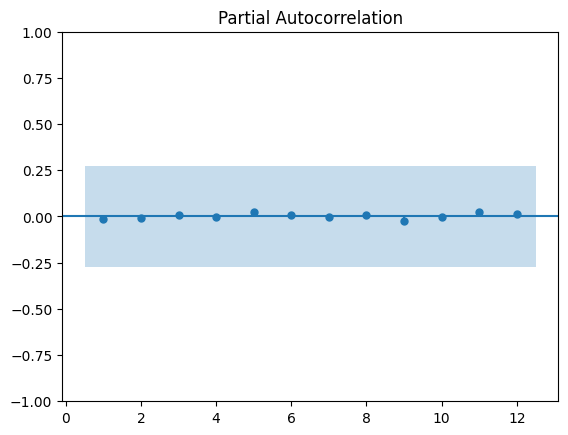

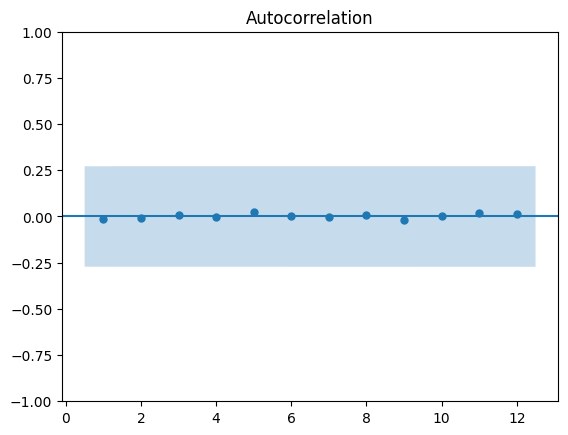

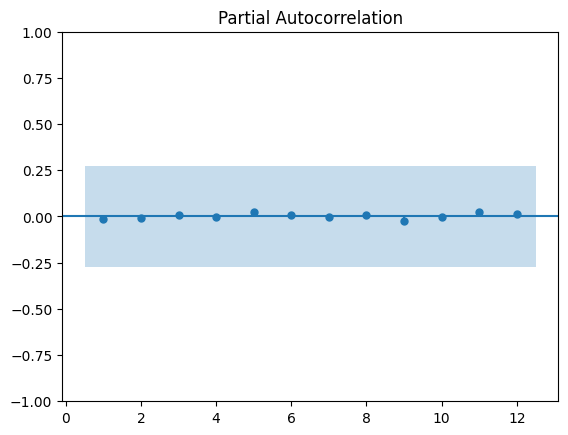

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(mydata['Close'], order=(0,1,0))  
fitted = model.fit()
fitted.summary()
resids= fitted.resid
lags=12

### Kiểm định tương quan chuỗi BG 
chi2=np.zeros(lags)
probChi2=np.zeros(lags)
F=np.zeros(lags)
probf=np.zeros(lags)
for i in range(lags):
    chi2[i],probChi2[i],F[i],probf[i] = sm.stats.diagnostic.acorr_breusch_godfrey(fitted,i+1)
BG_test = pd.DataFrame({'Chi-Sq': chi2, 'Prob>Chi-Sq': probChi2,
                        'F': F, 'Prob>F': probf}, index=range(1,lags+1))
print(BG_test)


### Kiểm định tương quan chuỗi Ljing-Box test

lags =12  # required for the following tests
jb, jbpv, bp, bppv = sm.stats.diagnostic.acorr_ljungbox(resids,lags,True,return_df=False)
JB_test = pd.DataFrame({'Jung-Box': jb, 
                    'JB-P-val': jbpv,
                   'Box-Pierce': bp, 
                   'BP-P-val': bppv},
                   index=range(1,lags+1))
print(JB_test)


# check for residual autocorrelation ACF and PACF
import statsmodels.graphics.tsaplots as tsaplt
import statsmodels.tsa.api as tsa

acf, acf_confint, lbq, lbqpv = tsa.acf(resids, nlags=lags, alpha=0.05, qstat=True, fft=False)
pacf, pacf_confint = tsa.pacf(resids, nlags=lags, alpha=0.05)
acf_se = (acf_confint[:,1]-acf)/1.96
pacf_se = (pacf_confint[:,1]-pacf)/1.96

ACF_table = pd.DataFrame({'AR': acf[1:], 'AR_se': acf_se[1:], 
                          'PAR': pacf[1:], 'PAR_se': pacf_se[1:], 
                          'Ljung-Box Q': lbq, 'Q_pval': lbqpv},
                    index=range(1,lags+1))
print(ACF_table)

# plots of ACF and Pacf
tsaplt.plot_acf(fitted.resid, lags=lags, zero=False)
tsaplt.plot_pacf(fitted.resid, lags=lags, zero=False)





In [ ]:

predictions = fitted.predict(start=0, end=51, dynamic=False).rename('ARIMA(0,1,0) Dự báo')
for i in range(len(predictions)):
    print(f"Giá trị dự báo={predictions[i]:<11.10}, Giá trị thực tế={mydata['Close'][i]}")
title = 'Kết quả dự báo trong mẫu'


Giá trị dự báo=0.0        , Giá trị thực tế=1528.48
Giá trị dự báo=1528.48    , Giá trị thực tế=1496.02
Giá trị dự báo=1496.02    , Giá trị thực tế=1472.89
Giá trị dự báo=1472.89    , Giá trị thực tế=1478.96
Giá trị dự báo=1478.96    , Giá trị thực tế=1478.96
Giá trị dự báo=1478.96    , Giá trị thực tế=1501.71
Giá trị dự báo=1501.71    , Giá trị thực tế=1504.84
Giá trị dự báo=1504.84    , Giá trị thực tế=1498.89
Giá trị dự báo=1498.89    , Giá trị thực tế=1505.33
Giá trị dự báo=1505.33    , Giá trị thực tế=1466.54
Giá trị dự báo=1466.54    , Giá trị thực tế=1469.1
Giá trị dự báo=1469.1     , Giá trị thực tế=1498.5
Giá trị dự báo=1498.5     , Giá trị thực tế=1516.44
Giá trị dự báo=1516.44    , Giá trị thực tế=1482.0
Giá trị dự báo=1482.0     , Giá trị thực tế=1458.56
Giá trị dự báo=1458.56    , Giá trị thực tế=1379.23
Giá trị dự báo=1379.23    , Giá trị thực tế=1366.8
Giá trị dự báo=1366.8     , Giá trị thực tế=1329.26
Giá trị dự báo=1329.26    , Giá trị thực tế=1182.77
Giá trị dự báo=1

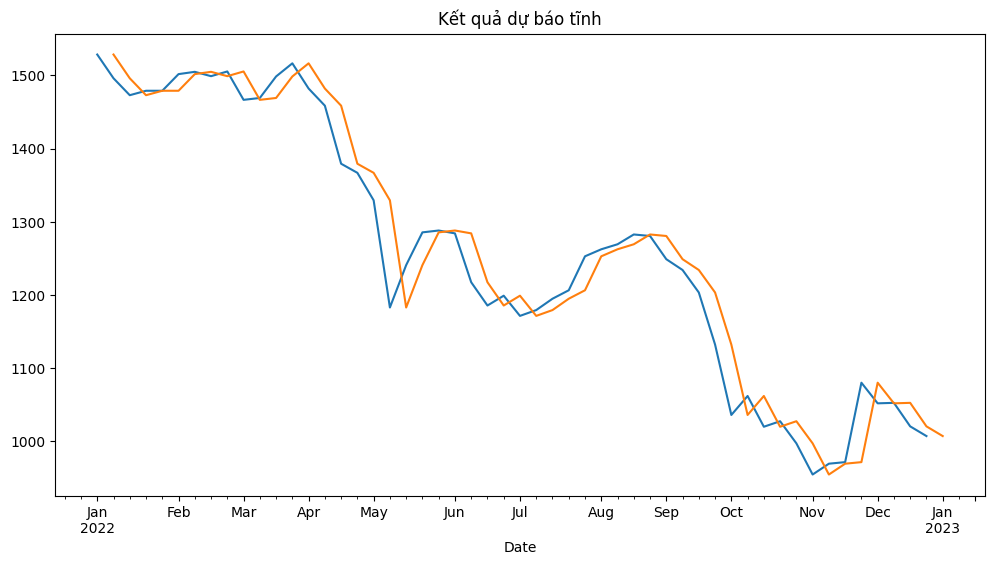

In [ ]:



dynamic = fitted.predict(start=1, end=52, dynamic=False).rename('ARIMA(0,1,0) Forecast')
title = 'Kết quả dự báo tĩnh'
xlabel='Week' 
ax = mydata['Close'].plot(legend=False,figsize=(12,6),title=title)
dynamic.plot(legend=False)
ax.autoscale(axis='x',tight=False)


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], dynamic)
RMSE = rmse(mydata['Close'], dynamic)
MAE = mean_absolute_error(mydata['Close'], dynamic)
MAPE = np.mean(np.abs(dynamic - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,0) MAPE : {MAPE:11.10}')

ARIMA(0,1,0) MSE :         0.0
ARIMA(0,1,0) RMSE :         0.0
ARIMA(0,1,0) MAE :         0.0
ARIMA(0,1,0) MAPE : 0.02422821193


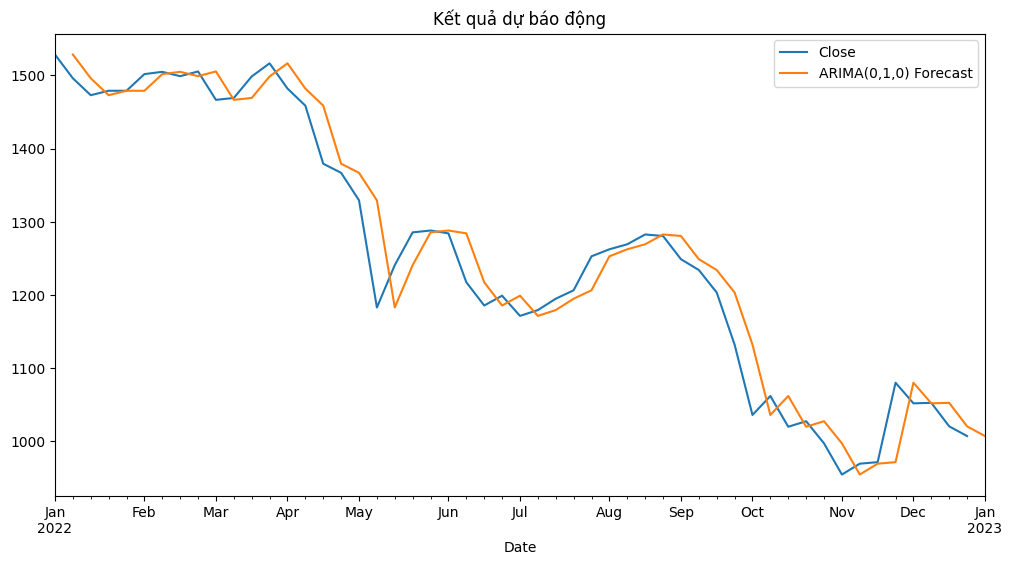

In [ ]:
static = fitted.predict(start=1, end=52, dynamic=False).rename('ARIMA(0,1,0) Forecast')
title = 'Kết quả dự báo động'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
static.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], static)
RMSE = rmse(mydata['Close'], static)
MAE = mean_absolute_error(mydata['Close'], static)
MAPE = np.mean(np.abs(static - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,0) MAPE : {MAPE:11.10}')

In [ ]:
dynamic = fitted.predict(start=1, end=52+10, dynamic=False).rename('ARIMA(0,1,0) Forecast')
title = 'Kết quả dự báo tĩnh ngoài mẫu 10 kỳ'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
dynamic.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

dateparse1 = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y') 
  
data36month = pd.read_csv('C:/Users/HL2020/Downloads/Dữ liệu Lịch sử VN Index (9).csv',index_col='Date',parse_dates=['Date'], date_parser=dateparse1).fillna(0)
data36month['Close'].plot(figsize=(16, 5))
result = seasonal_decompose(data36month['Close'], model='multiplicative')
fig = result.plot()
fig.set_size_inches(16, 5)

In [ ]:
plot_pacf(data36month['Close'])
plot_acf(data36month['Close'])
test_stationarity(data36month['Close'])


In [ ]:
d_data36month=diff(data36month['Close'])
test_stationarity(d_data36month)
plot_pacf(d_data36month)
plot_acf(d_data36month)

In [ ]:

model_sarima = auto_arima(data36month['Close'], start_p=0, start_q=0,
                           max_p=5, max_q=5, m=False,
                           start_P=False, seasonal=False,
                           d=1, D=False, trace=False,
                           error_action='ignore',  
                           suppress_warnings=False, 
                           stepwise=False)




model_sarima.summary()
